# Turbulencja
### Ogólne warunki
Notebook od Antka

In [1]:
import datetime
from math import exp
from rocketpy import Environment, Rocket, Flight, Fluid, LiquidMotor, CylindricalTank, MassFlowRateBasedTank
# lot TRB w goolg earth
# https://earth.google.com/web/@52.95723596,18.60175858,68.34175079a,4431.88222566d,35y,16.94871295h,41.34729834t,-
# 0r/data=CgRCAggBMikKJwolCiExclVLeGw3VjctMzRRZDlIRkZqT2pNOENWeVhDbEFzbnQgAUICCABKBwjzj4hpEAE

### lokacja
ta sekcja jest raczej skonczona


Gravity Details

Acceleration of gravity at surface level:    9.8131 m/s²
Acceleration of gravity at  10.000 km (ASL): 9.7825 m/s²


Launch Site Details

Launch Date: 2025-07-27 14:00:00 UTC
Launch Site Latitude: 52.94402°
Launch Site Longitude: 18.63891°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 744479.23 E    5872242.14 N
Launch Site UTM zone: 33U
Launch Site Surface Elevation: 81.0 m


Atmospheric Model Details

Atmospheric Model Type: Windy
Windy Maximum Height: 10.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 3.84 m/s
Surface Wind Direction: 74.59°
Surface Wind Heading: 254.59°
Surface Pressure: 1000.00 hPa
Surface Temperature: 273.42 K
Surface Air Density: 1.274 kg/m³
Surface Speed of Sound: 331.48 m/s


Earth Model Details

Earth Radius at Launch site: 6364.56 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



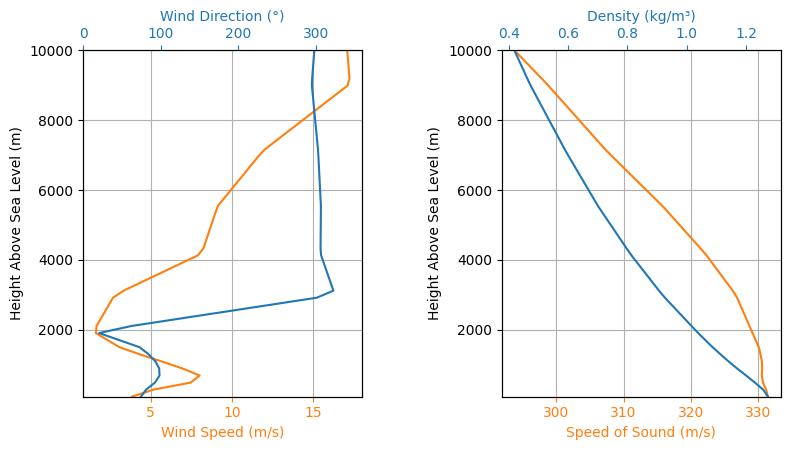

In [2]:
env = Environment(latitude=52.94401645806493, longitude=18.63890735729045)
# 52.94401645806493, 18.63890735729045 toruń poligon <----
moment = datetime.date.fromisoformat('2025-07-27')
env.set_date((moment.year, moment.month, moment.day, 14))  # godizna w UTC (tam byla 15:51 GMT+2)
env.set_atmospheric_model(type="Windy", file="GFS")
# to ponizej to uproszczony przypadek
# env.set_atmospheric_model(
#     type="custom_atmosphere",
#     pressure=None,
#     temperature=None,
#     wind_u=[(0, .3048*14.7), (10000, .3048*14.7)],
#     wind_v=[(0, 0), (10000, 0)],
# )
env.max_expected_height = 10000
# env.export_environment("../atmos02") 
# wykonuje te komende w kodzie AB aby potem pobrac dane pogodowe do 'konkutera pokladowego'
env.info()

### zawisza
to wymaga dobrego pomyślunku (zgrania z openrocket)

Nozzle Details
Nozzle Radius: 0.036 m

Motor Details
Total Burning Time: 15 s
Total Propellant Mass: 22.250 kg
Structural Mass Ratio: 0.108
Average Propellant Exhaust Velocity: 1590.063 m/s
Average Thrust: 1584.121 N
Maximum Thrust: 4575.401 N at 1.2244897959183674 s after ignition.
Total Impulse: 23761.813 Ns



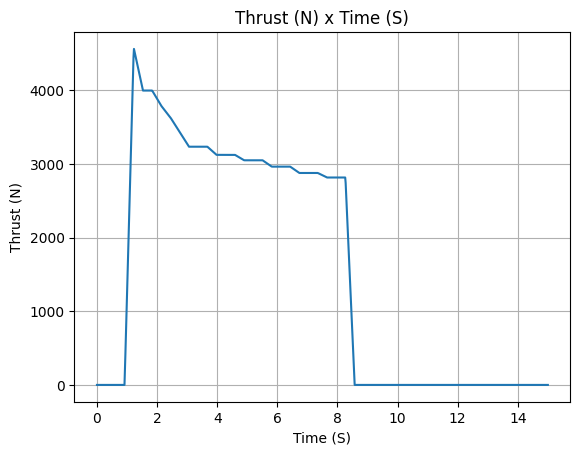


Tank 'oxidizer tank' Data:

Tank Geometry:
Average radius 0.100 m
Bottom: -0.5 m
Top: 0.5 m
Total height: 1.0 m
Total volume: 0.031416 m^3

Tank 'oxidizer tank' Fluid Parameters:

Liquid Fluid
Name: N2O_l
Density: 1230.0000 kg/m^3

Gas Fluid
Name: N2O_g
Density: 1.9277 kg/m^3

Tank 'oxidizer tank' Mass Flux Data:

Initial Quantities at t = 0.00 s:
Initial Fluid Mass: 1.800e+01 kg
Initial Liquid Volume: 1.463e-02 m^3
Initial Liquid Level: -3.418e-02 m

Final Quantities at t = 20.00 s:
Final Fluid Mass: 8.853e+00 kg
Final Liquid Volume: 7.198e-03 m^3
Final Liquid Level: -2.709e-01 m


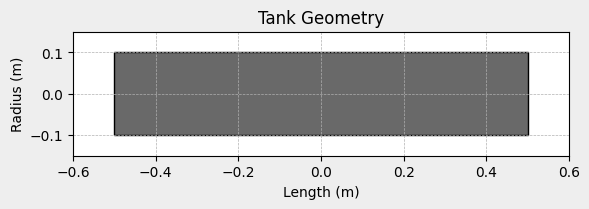

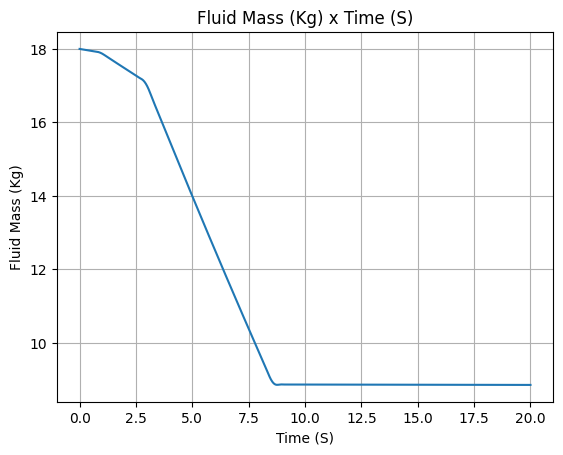

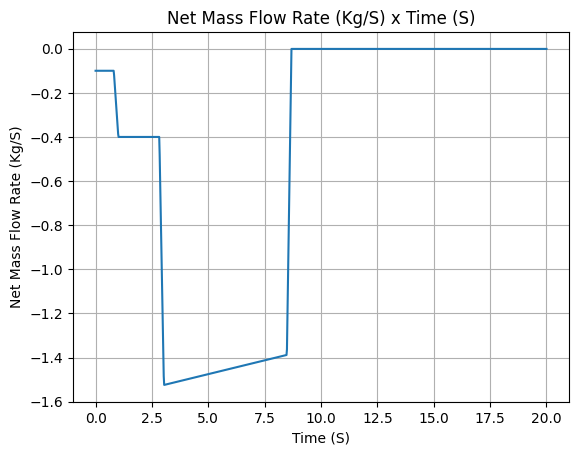

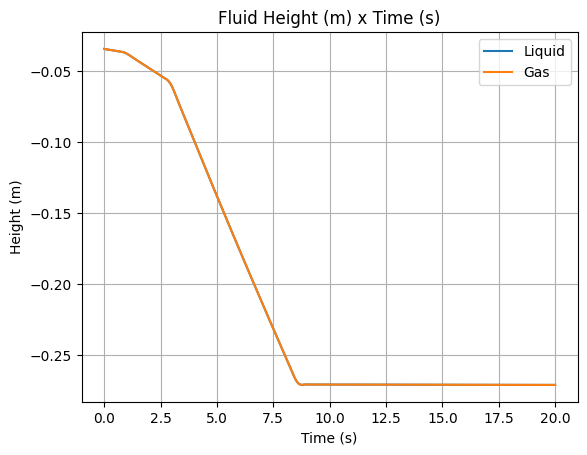

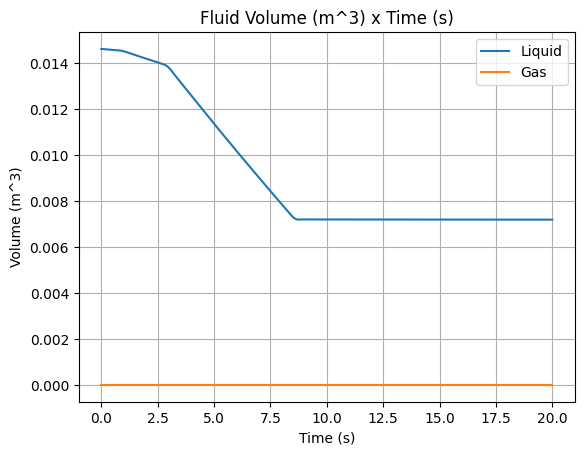

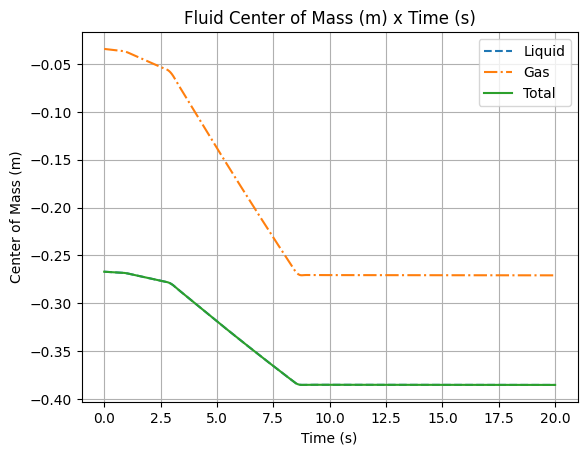

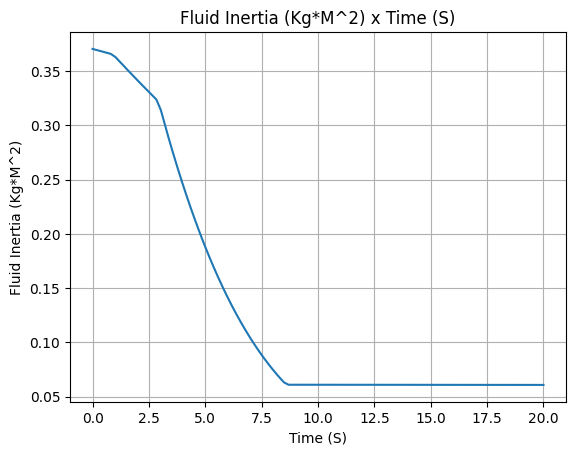


Tank 'fuel tank' Data:

Tank Geometry:
Average radius 0.100 m
Bottom: -0.175 m
Top: 0.175 m
Total height: 0.35 m
Total volume: 0.010996 m^3

Tank 'fuel tank' Fluid Parameters:

Liquid Fluid
Name: ethanol_l
Density: 789.0000 kg/m^3

Gas Fluid
Name: ethanol_g
Density: 1.5900 kg/m^3

Tank 'fuel tank' Mass Flux Data:

Initial Quantities at t = 0.00 s:
Initial Fluid Mass: 4.250e+00 kg
Initial Liquid Volume: 5.387e-03 m^3
Initial Liquid Level: -3.540e-03 m

Final Quantities at t = 20.00 s:
Final Fluid Mass: 2.210e+00 kg
Final Liquid Volume: 2.801e-03 m^3
Final Liquid Level: -8.583e-02 m


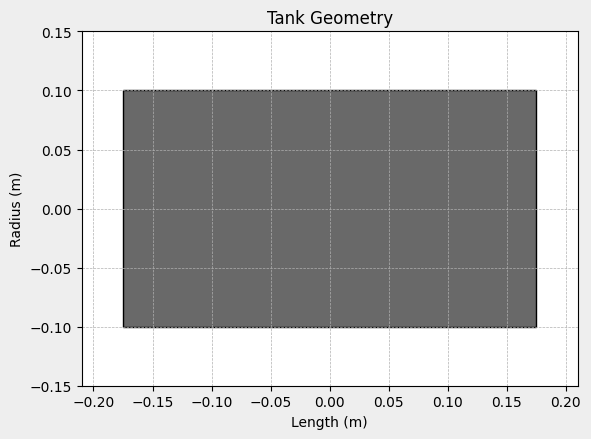

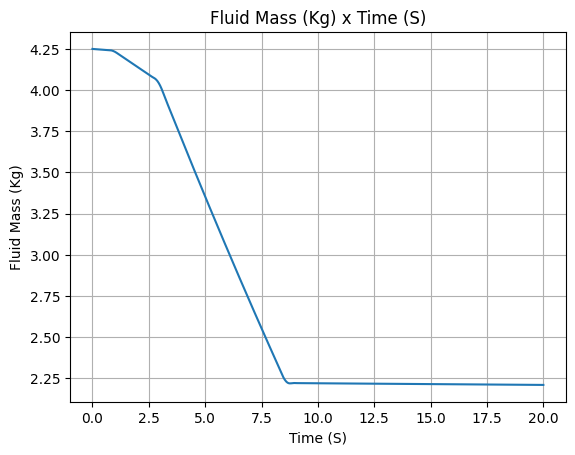

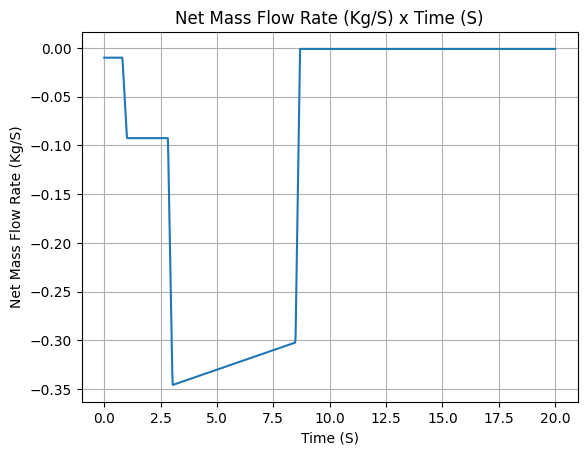

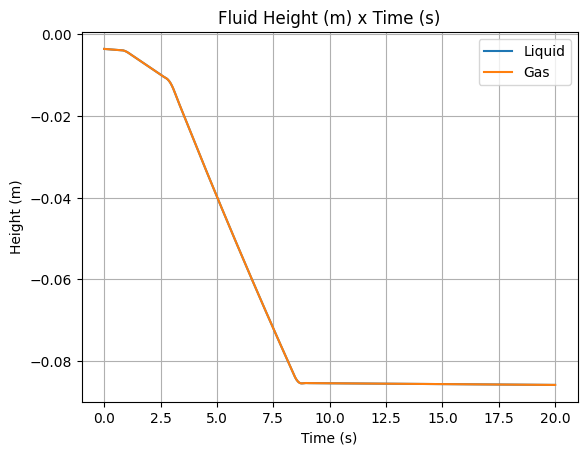

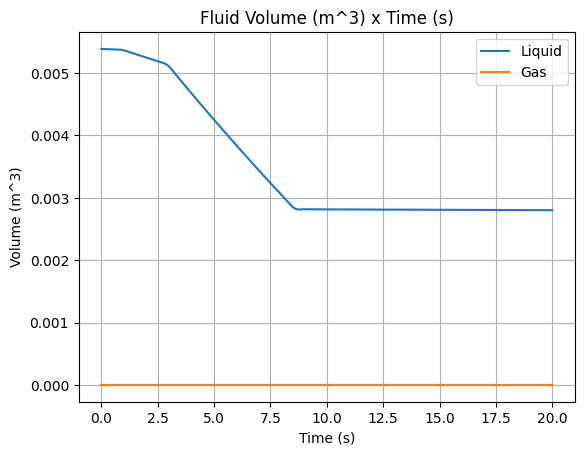

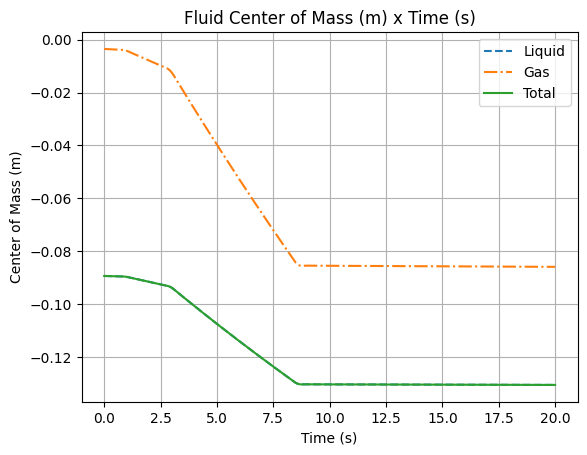

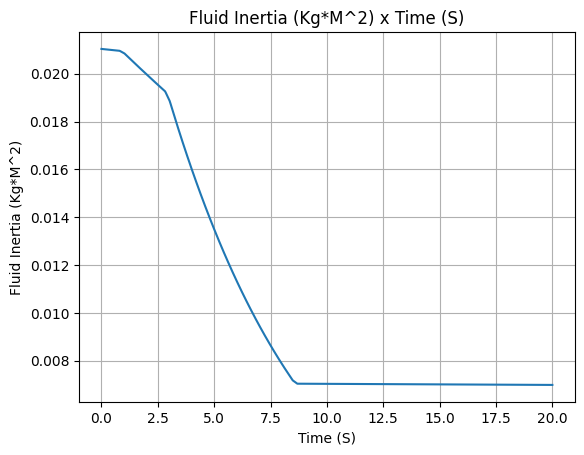

In [3]:
# ciecze
oxidizer_liq =  Fluid(name="N2O_l",     density=1230)
oxidizer_gas =  Fluid(name="N2O_g",     density=1.9277)
fuel_liq =      Fluid(name="ethanol_l", density=789)
fuel_gas =      Fluid(name="ethanol_g", density=1.59)

# Key flight variables
engine_cut_off_time = 8.55

# Define tanks geometry
fuel_shape = CylindricalTank(radius = 0.1, height = 0.35, spherical_caps = False)
ox_shape = CylindricalTank(radius = 0.1, height = 1, spherical_caps = False)
        
def mass_flow_rate_ox(t, cut_off = 8.55) -> float:
    if t > cut_off:
        return 0.001
    if t < 1:
        return 0.1
    elif t < 3:
        return 0.4
    elif t < 10:
        return 1.6 - t * 0.025
    else:
        return 237.47895461546*exp(-0.5*t)/1.2
    
def mass_flow_rate_fuel(t, cut_off = 8.55) -> float:
    if t > cut_off:
        return 0.001
    if t < 1:
        return 0.01
    if t < 3:
        return 0.0925
    elif t < 10:
        return 0.37 - t * 0.008
    else: 
        return 54.923258254825*exp(-0.5*t)/1.5


# Define tanks
oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry=ox_shape,
    flux_time=20,
    initial_liquid_mass=18,
    initial_gas_mass=0,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=lambda t: mass_flow_rate_ox(t, engine_cut_off_time),
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=oxidizer_liq,
    gas=oxidizer_gas,
)

fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry=fuel_shape,
    flux_time=20,
    initial_liquid_mass=4.25,
    initial_gas_mass=0,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=lambda t: mass_flow_rate_fuel(t, engine_cut_off_time),
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=fuel_liq,
    gas=fuel_gas,
)

def thrust_func(t, cut_off = 16.957) -> float:
    thrust = [
        (0,0),
(	0.921	,	49.198	)	,
(	1.089	,	4575.401	)	,
(	1.361	,	3997.326	)	,
(	1.968	,	3788.235	)	,
(	2.303	,	3628.342	)	,
(	2.575	,	3431.551	)	,
(	2.973	,	3234.759	)	,
(	3.748	,	3124.064	)	,
(	4.083	,	3124.064	)	,
(	4.732	,	3050.267	)	,
(	5.695	,	2964.171	)	,
(	6.595	,	2878.075	)	,
(	7.579	,	2816.578	)	,
(	8.5	,	2742.781	)	,
(	9.463	,	2656.684	)	,
(	10.363	,	2607.487	)	,
(	10.95	,	2496.791	)	,
(	11.284	,	1918.717	)	,
(	11.431	,	1168.449	)	,
(	11.745	,	418.182	)	,
(	12.352	,	258.289	)	,
(	14.111	,	245.989	)	,
(	15.786	,	221.39	)	,
(	16.121	,	61.497	)	,
(	16.958	,	0	)]
    last_val = 0
    if t > cut_off:
        return 0
    for time, val in thrust:
        if time <= t:
            last_val = val
    return last_val

# chciałem zrobic funckje która zmienia srodek cięzkosci gdy tłok sie przesuwa. nie zrobiłem jak widac
Z4000 = LiquidMotor(
    thrust_source=lambda t: thrust_func(t, engine_cut_off_time),
    dry_mass=2.700,
    dry_inertia=(0.125, 0.125, 0.002),      # nie ma
    nozzle_radius=0.036,                    # nie ma
    center_of_dry_mass_position=0.288/2,  # 
    nozzle_position=0,
    burn_time=15,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
Z4000.add_tank(tank=oxidizer_tank, position=0.755+0.5)
Z4000.add_tank(tank=fuel_tank, position=0.755+1+0.175)

Z4000.info()
oxidizer_tank.all_info()
fuel_tank.all_info()

### aerodynamika

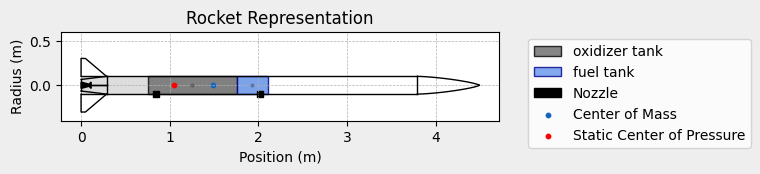

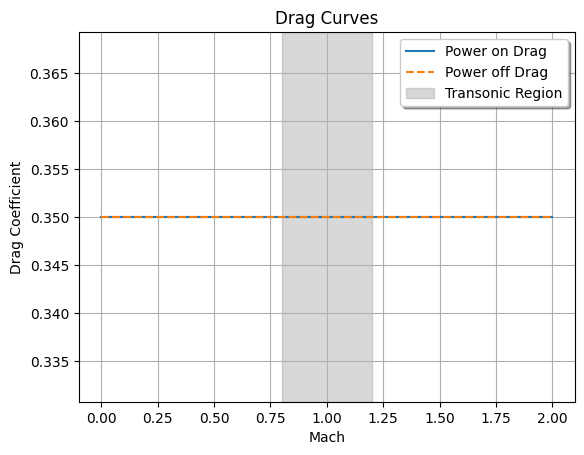

In [4]:
# ta funkcja czeka na legitne dane z symulacji CFD
def prometheus_cd_at_ma(mach):
    """Gives the drag coefficient of the rocket at a given mach number."""
    if mach <= 0.15:
        return 0.422
    elif mach <= 0.45:
        return 0.422 + (mach - 0.15) * (0.38 - 0.422) / (0.45 - 0.15)
    elif mach <= 0.77:
        return 0.38 + (mach - 0.45) * (0.32 - 0.38) / (0.77 - 0.45)
    elif mach <= 0.82:
        return 0.32 + (mach - 0.77) * (0.3 - 0.32) / (0.82 - 0.77)
    elif mach <= 0.88:
        return 0.3 + (mach - 0.82) * (0.3 - 0.3) / (0.88 - 0.82)
    elif mach <= 0.94:
        return 0.3 + (mach - 0.88) * (0.32 - 0.3) / (0.94 - 0.88)
    elif mach <= 0.99:
        return 0.32 + (mach - 0.94) * (0.37 - 0.32) / (0.99 - 0.94)
    elif mach <= 1.04:
        return 0.37 + (mach - 0.99) * (0.44 - 0.37) / (1.04 - 0.99)
    elif mach <= 1.24:
        return 0.44 + (mach - 1.04) * (0.43 - 0.44) / (1.24 - 1.04)
    elif mach <= 1.33:
        return 0.43 + (mach - 1.24) * (0.42 - 0.43) / (1.33 - 1.24)
    elif mach <= 1.49:
        return 0.42 + (mach - 1.33) * (0.39 - 0.42) / (1.49 - 1.33)
    else:
        return 0.39

# inertia do siorbnięcia z cad-a
turbulence = Rocket(
    radius=0.1,
    mass=58.367,
    inertia=(363.24711983, 363.29364937, 0.3688369952),
    # power_off_drag=lambda x: prometheus_cd_at_ma(x),
    # power_on_drag=lambda x: prometheus_cd_at_ma(x),
    power_off_drag=.35,
    power_on_drag=.35,
    center_of_mass_without_motor=4.49-2.82,
    coordinate_system_orientation="tail_to_nose",
)

turbulence.add_motor(Z4000, position=0)

# raczej aktualne wzgl. OR
rail_buttons = turbulence.set_rail_buttons(
    upper_button_position=4.49-2.47,
    lower_button_position=4.49-3.65,
    angular_position=45,
)

nose_cone = turbulence.add_nose(
    length=0.7, kind="von karman", position=4.490
)

# radze uwazac bo niematematyczna geometria moze sprawic ze Flight sie wyjebie po kilku-nastu sekundach 
# nie podając konkretnego błędu
fin_set = turbulence.add_trapezoidal_fins(
    n=4,
    root_chord=0.287,
    tip_chord=0.049,
    span=0.202,
    position=0.287,
    cant_angle=0.5,
    airfoil=None,
)

tail = turbulence.add_tail(
    top_radius=0.1, bottom_radius=0.065, length=0.287, position=0.287
)

# nie mam pojecia czy te pany są aktualne @Recovery 

main = turbulence.add_parachute(
    name="Main",
    cd_s=15.9,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

drogue = turbulence.add_parachute(
    name="Drogue",
    cd_s=.25,        # oklapnięty
    trigger="apogee",
    sampling_rate=105,
    lag=5,
    noise=(0, 8.3, 0.5),
)

turbulence.draw()
turbulence.plots.drag_curves()

### lot


Maximum Values

Maximum Speed: 215.544 m/s at 8.46 s
Maximum Mach Number: 0.656 Mach at 8.46 s
Maximum Reynolds Number: 2.984e+06 at 8.43 s
Maximum Dynamic Pressure: 2.749e+04 Pa at 8.43 s
Maximum Acceleration During Motor Burn: 45.236 m/s² at 1.23 s
Maximum Gs During Motor Burn: 4.613 g at 1.23 s
Maximum Acceleration After Motor Burn: 13.121 m/s² at 10.02 s
Maximum Gs After Motor Burn: 1.338 Gs at 10.02 s
Maximum Stability Margin: 2.743 c at 8.54 s
Maximum Upper Rail Button Normal Force: 0.198 N
Maximum Upper Rail Button Shear Force: 2.698 N
Maximum Lower Rail Button Normal Force: 0.129 N
Maximum Lower Rail Button Shear Force: 1.759 N

Apogee State

Apogee Time: 28.146 s
Apogee Altitude: 2920.956 m (ASL) | 2851.956 m (AGL)
Apogee Freestream Speed: 24.744 m/s
Apogee X position: 297.961 m
Apogee Y position: 357.693 m
Apogee latitude: 52.9472364°
Apogee longitude: 18.6433590°
-27.836006465309033


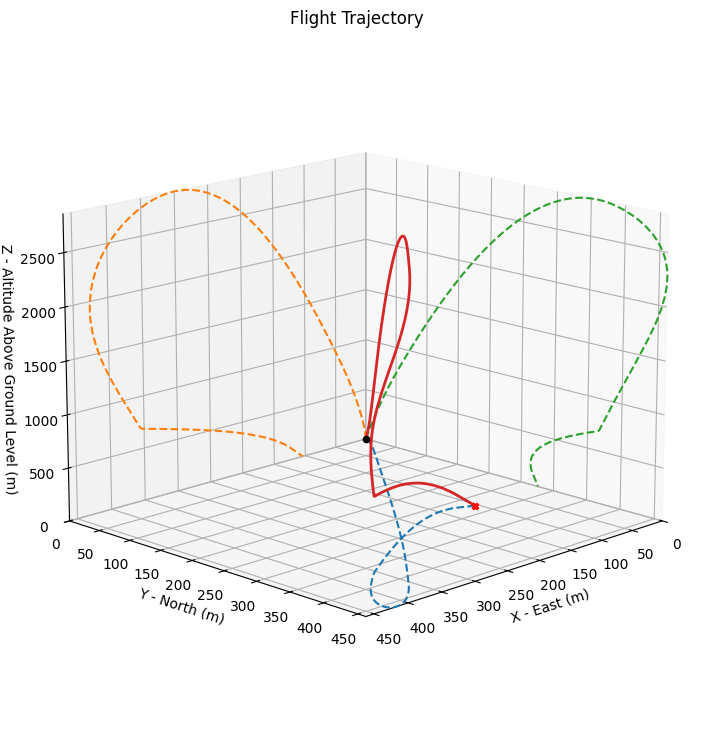

In [6]:

# ngl straciłem parametry które dawały iluzje lotu jak w Toruniu
test_flight = Flight(rocket=turbulence, environment=env, rail_length=6, inclination=87, heading=20)

test_flight.prints.maximum_values()
test_flight.prints.apogee_conditions()
print(3.6*test_flight.impact_velocity)
test_flight.plots.trajectory_3d()


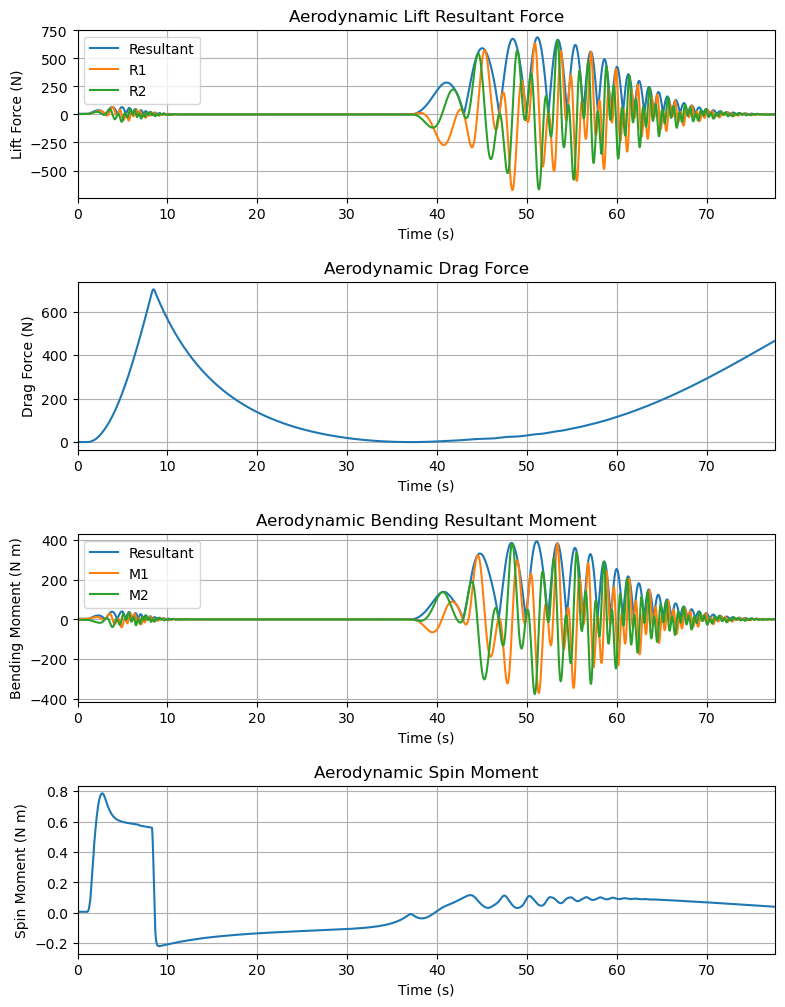

In [ ]:

test_flight.plots.aerodynamic_forces()
# flight_plots._FlightPlots.trajectory_3d(test_flight)